# Mapmaking

### Code from Sigurd Naess, addapted by Jeff McMahon


CMB telescopes observe by scanning accross the sky and recording the response of each detector as a funciton of time as well as pointing information.  The detector response time series is commonly refered to as time ordered data or a TOD.  Each CMB field is usually observed many times over the course of one or more seasons yielding a large nunber of overlapping TODs.   At the pole the sky rotation is alligmed with the elevation axis of a telescope resulting in paralell scans in sky coordinates.  At midlattitude sites there is no such alignment and sky rotation can produce cross-linked scans.  Offline the TODs are processed to reconstruct the maps.   

In this notebook you will (1) model TODs for a map that is obsered horizontally and vertically to create a cross-linked set of TODs, (2) add 1/f noise to create TODs similar to what would be output from a CMB instrument, and (3) you will use several mapmaking codes to reconstruct maps from these time streams.   The mapmaking codes include (i) a simple binned average that works well if the TODs have negliagble white noise (from the instrument (e.g., ddemodulated half-wave plate polarziation data) or by prewhitening the data with a filter), and (ii) an iterative maximum liklihood mapmaker that accounts for the noise correlations from the atmosphere.

Excercises will guide you through the differences between cross-linked and non-crosslinked maps, and the impacts of filtering before and after mapmaking.


## First we read in the necessary libraries from previous code modules.

In [1]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

#%cd /Users/reneehlozek/Dropbox/ACTSummerSchool  ## put your directory where the maps and libraries live here
%matplotlib inline
import constants as cs # the constants module

from cmb_modules import * # the module of functions
N = int(cs.N)
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size
print("pixel size: ", pix_size)

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

pixel size:  0.5


## Recalculating the results from the previous stages

This creates a map with CMB, point sources, and SZ sources.  It also convolces the map with the beam.  Unlike previous maped based simulations, noise will be added in the time series which are calculated below.

Number of sources required:  5000
map mean: -8.21974344018137 map rms: 99.55836631317621


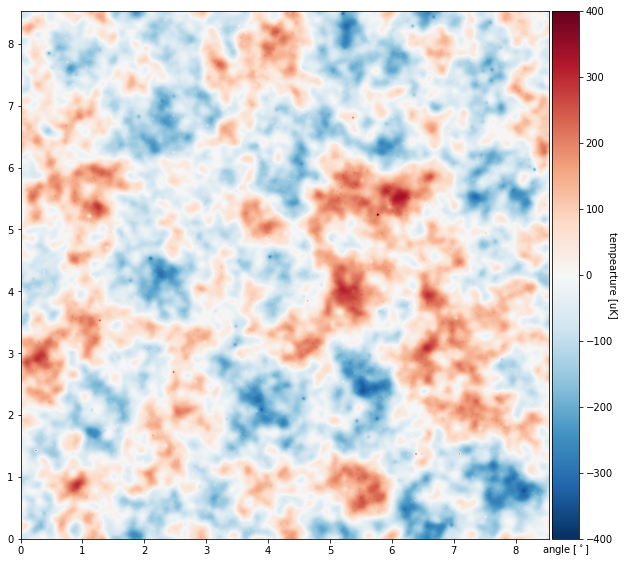

In [2]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

## make a point source map
PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,\
                                  Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap


## convolve with the beam
CMB_T_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)

## plot the result
p=Plot_CMB_Map(CMB_T_convolved,c_min,c_max,X_width,Y_width)



## save the result as "sky", a variable that represents the simulated sky we will map below
sky = total_map

## Generating time streams from a simulated sky map

This is the first new piece of the notebook.  In this section we simulate the telesacope scanning accross the map.  For simplicity we consider two scan directions: left-right, and up-down. This code generates a list of pixels (x- and y coordinates) in the order in which they are observed.  



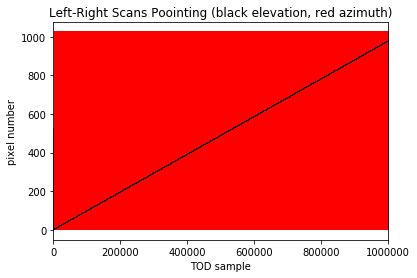

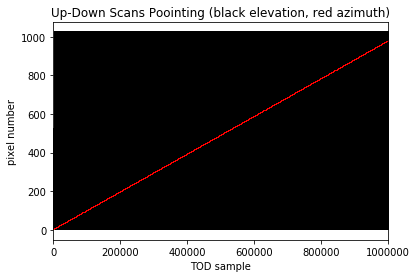

In [3]:

## a function to return the sequence of pixel indices as they are "observed" in these simualtions
def sim_pointing(map, dir=0):
    """Simulate a telescope scanning across the given map. The scanning pattern is
    as simple as possible: The samples hit the center of each pixel, and we
    scan rowwise (dir=0) or columnwise (dir=1)."""
    # The pointing is an [{y,x},nsamp] array of pixel positions
    # The einsum stuff is just to swap the second and third axis
    # of pixmap, which contains the pixel coordinates of each pixel.
    pixmap = np.mgrid[:map.shape[-2],:map.shape[-1]]  ## makes two arrays of the x and y indices in the map
    pixmap[1,1::2, :] = pixmap[1,1::2, ::-1]          ## reverse ever other row so the scans go back and forth
    if dir == 0: point = pixmap.reshape(2,-1)         ## arranges these for L-R scans
    else:        point = np.roll(pixmap,1,axis=0).reshape(2,-1)   ## arranges these for U-D scans
    return point




## generate left-right scans
point_lr = sim_pointing(sky, 0)

## generate Up-Down scans
point_ud = sim_pointing(sky, 1)




plt.plot(point_lr[1,:],"r,")
plt.plot(point_lr[0,:],"k,")
plt.title("Left-Right Scans Poointing (black elevation, red azimuth)")
plt.ylabel("pixel number")
plt.xlabel("TOD sample")
plt.xlim(0,1e6)
plt.show()

plt.plot(point_ud[0,:],"k,")
plt.plot(point_ud[1,:],"r,")
plt.title("Up-Down Scans Poointing (black elevation, red azimuth)")
plt.ylabel("pixel number")
plt.xlabel("TOD sample")
plt.xlim(0,1e6)
plt.show()

<font color='red'>EXCERCISE: </font>  Make a zoomed in plot of the scan strategies above by adjusting the x limit for the plot to be much smaller.     Discribe the scan strategy based on what you see in these plots.

In [4]:
# make your plots here

#### discusson goes here

### noisless TODs

This code takes the pointing information genrated above an makes a mock TOD with no noise.

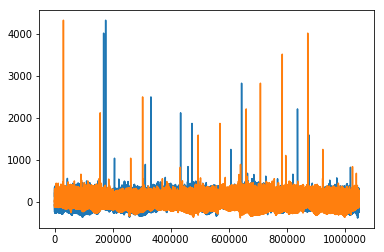

In [5]:
def Observe_map(map, point):
    """Pointing matrix: Project map to tod"""
    point = np.round(point).astype(int)
    return map[point[0],point[1]]  ## return the value of the map at each pointing, this forms the simulated time stream



noisless_tod_lr = Observe_map(sky, point_lr)
noisless_tod_ud = Observe_map(sky, point_ud)



plt.plot(noisless_tod_lr)
plt.plot(noisless_tod_ud)
plt.show()


<font color='red'>EXCERCISE: </font>  Explain the spikes in the TOD and discuss weather the RMS of the TOD makes sense.

#### discussion goes here

<font color='red'>OPTIONAL EXCERCISE: </font> Add in the impact of detector time constants to smear out these TODs.  This excercise is best done aftern completig the rest of the notebook so its impact can be propigatd through this entire code to maps.  This will allow you to model the impact of this sytematic on effect.

NOTE: [this wikipedia article](https://en.wikipedia.org/wiki/Exponential_smoothing) is useful in modeling exponetial filters (e.g., detector time cosntants) This apporach can be implemented with arrays using the np.roll funciton.

### Adding noise to the TOD

Here we build a noise power spectrum for the atmospheric and instrumental noise.   By default we assume the instrumental noise has an amplitude of 40 $\mu$-K per sample (1/2 arcmin pixels) which is similar to the full exposure of ACT-MBAC or SPT-SZ which were around 20 $\mu$ K- arcmin (SPT was slightly lower).   The atmospehric signal is modeled as a simple power law with a 0.1 s 1/f knee and a scan that speends $1/240$ s in each pixel which is equivelent to a $1^\circ/$s scan speed.   


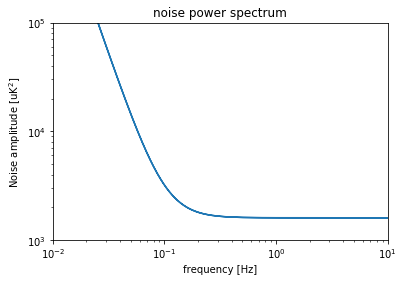

In [6]:
def sim_noise_spec(nsamp, dt=.00416, fknee=0.1, alpha=3, sigma=40):
    """Build a simple atmosphere + white noise model, and return it
    as a power spectrum."""
    freq   = np.abs(np.fft.fftfreq(nsamp, dt))
    return (1+(np.maximum(freq,freq[1])/fknee)**-alpha)*sigma**2



noise_spec_lr = sim_noise_spec(point_lr.shape[-1], dt=.00416, fknee=0.1, alpha=3, sigma=40)
noise_spec_ud = sim_noise_spec(point_ud.shape[-1], dt=.00416, fknee=0.1, alpha=3, sigma=40)
freq   = np.abs(np.fft.fftfreq(point_lr.shape[-1], .00416))

plt.loglog(freq,noise_spec_lr)
plt.title("noise power spectrum")
plt.xlabel("frequency [Hz]")
plt.ylabel("Noise amplitude [uK$^{2}$]")
plt.ylim(1e3,1e5)
plt.xlim(1e-2,10)
plt.show()


The next step is to generate a realziation of this noise and add it to the noisless time series.

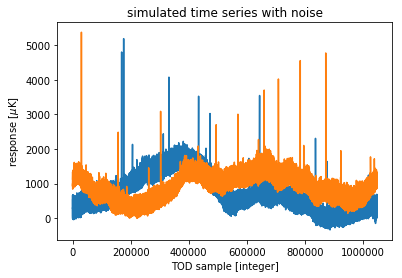

In [7]:
def sim_tod(map, point, noise_spec):
    """Simulate a noisy TOD using the model d = Pm + n"""
    tod    = Observe_map(map, point)
    rand   = np.fft.fft(np.random.standard_normal(tod.shape[-1]))
    fnoise = rand * noise_spec**0.5
    tod   += np.fft.ifft(fnoise).real
    return tod



tod_lr = sim_tod(sky, point_lr, noise_spec_lr)
tod_ud = sim_tod(sky, point_ud, noise_spec_ud)

plt.plot(tod_lr)
plt.plot(tod_ud)
plt.title("simulated time series with noise")
plt.ylabel("response [$\mu$K]")
plt.xlabel("TOD sample [integer]")
plt.show()

<font color='red'>EXCERCISE: </font>  Typical detectors have noises of $\sim 300 \mu$K-$\sqrt{s}$.  Make a plot of what a time stream looks like with this instantaneous sensitivity so you can get a feel for what real data looks like.

### write down the noise and 1/f knee you choose here

In [8]:
## make your plots here

### Putting all the pieces together

For convenience, the following code bundles the TOD (singal and noise), with pointing information, and the noise spectrum into a class.   This object will be passed as input to the map making codes we develope below.

Generating noisy TOD simulations


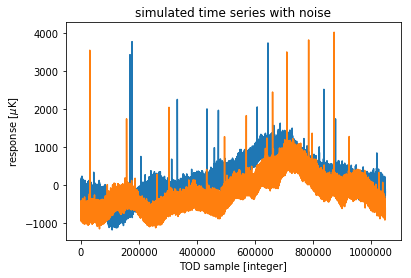

In [9]:
def sim_dataset(map, num_data=2, dt=.00416, fknee=0.1, alpha=3, sigma=40):
    """Simulate a dataset consisting of num_data scans across the sky.
    Returns a list of Data objects, each of which contains the tod,
    the pointing and the noise spectrum."""
    res = []
    for i in range(num_data):
        point = sim_pointing(map, i % 2)
        noise_spec = sim_noise_spec(point.shape[-1], dt=dt, fknee=fknee, alpha=alpha, sigma=sigma)
        tod = sim_tod(map, point, noise_spec)
        res.append(Data(tod, point, noise_spec))
    return res


class Data:
    def __init__(self, tod, point, noise_spec):
        self.tod   = tod
        self.point = point
        self.noise_spec = noise_spec




print("Generating noisy TOD simulations")
dataset  = sim_dataset(sky,num_data=2, dt=.00416, fknee=0.1, alpha=3, sigma=40)
for data in dataset:
    plt.plot(data.tod)
    
plt.title("simulated time series with noise")
plt.ylabel("response [$\mu$K]")
plt.xlabel("TOD sample [integer]")
plt.show()

# naieve mapmaking

Making maps from TODs is an inverse problem.  It can be epxressed in matrices as:
$$ P m = d.$$
Here $d$ is the TOD (whcih is a vector), $m$ is the sky map (whcih is also a vector), and $P$ is a (typically) rectangular matrix that specifies which pixel in the map was observed during each TOD sample.  (NOTE: many TOD sampeles usually correspond to the same pixel in our sky map.   

To solve for a map $m$ givein our TODs ($d$) we must invert this equaiton.   The standard technique is to use chi-squared minimizaiton.   Expressed in matries this apporach can be accomplised as derived here: 
$$ P m = d$$
$$ P^tP m  = P^t d      $$
$$ m = [P^tP]^{-1} P^t d.  $$

In other wordes, we can use the pointing matrix to construct a matrix $[P^tP]^{-1} P^t$ that acts on the TODs to return an estimate for the map.  The difficulty is implementing this when the numnber of smaples in the TODs are large, and in the presence of noise.

We have entirely ignored noise at this point.  (Noise correlations will be dealt with below.  
However, in the limit where the noise is white the above equation can be solved with a simple binned average.  In this case one simply averages the TOD samples which observae a given pixel and returns a map comprized of these averages.  We implement this below and highlight the value and limitations of such code.  (The value is it is fast)

Solving for map while ignoring noise correlations
map mean: -63.839324458157066 map rms: 327.7081815474741


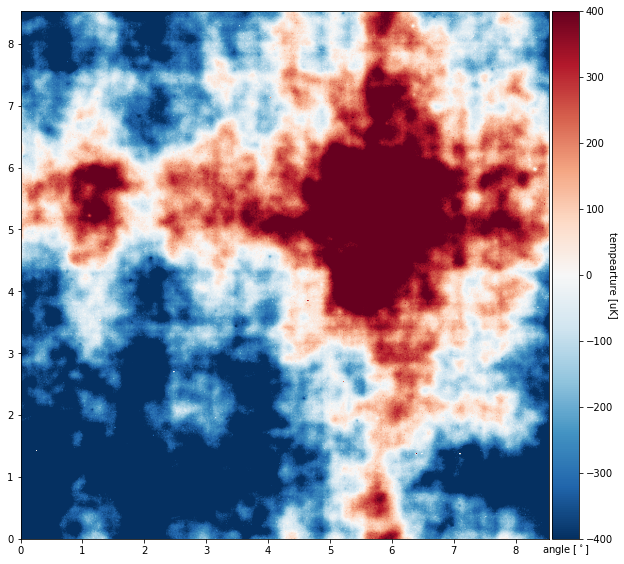

In [10]:
def solve_binned_average(dataset, shape):
    """Solve the simplified mapmaking equation Ax=b,
    where A = P'P and b = P'd, e.g. ignoring noise
    properties such as correlations."""
    rhs  = np.zeros(shape)
    hits = np.zeros(shape)
    for data in dataset:
        rhs  += PT(data.tod,    data.point, shape)
        hits += PT(data.tod*0+1, data.point, shape)
    return rhs/hits

def PT(tod, point, shape):
    """Transpose pointing matrix."""
    point = np.round(point).astype(int)
    point_flat = np.ravel_multi_index(point, shape[-2:])
    map = np.bincount(point_flat, tod, minlength=shape[-2]*shape[-1])
    map = map.reshape(shape[-2:])
    return map


print("Solving for map while ignoring noise correlations")
map_binned = solve_binned_average(dataset, sky.shape)
p=Plot_CMB_Map(map_binned,c_min,c_max,X_width,Y_width)
##p=Plot_CMB_Map(map_binned-sky,c_min,c_max,X_width,Y_width)  #for comparison 

<font color='red'>EXCERCISE: </font>  Do you see comon structures in this map and the input sky map?

comment here

<font color='red'>EXCERCISE: </font>  Remake the TOD and this map setting the 1/f knee to be absurly small.  Compare the new result to the originaly input map?

In [11]:
## code goes here

comment here

<font color='red'>EXCERCISE: </font>  reset the 1/f knee to its original value.  Now filter the time-series using a high-pass filter with a knee frequency set to whiten the TODs.   Remake the map and compare the new result to the input map.  What is different?

In [12]:
## code goes here

comment here

# maximum liklihood mapmaking including noise correlations

Based on what we have seen above we need to develope a map-making apporach that accounts for the noise correlations in our data.   To do this we implement a maximum liklihood mapmaking approiach.  Expressed with matrices this is much like what we did above, except we include weighting by a matrix $N;^{-2}$ whose matdix elements are $1/\sigma^2_{ij}$ and encode the weight of each sample and correlations between samples in the TOD.   WIth this matrix our mapmaking apporach can be derived as follows: 
$$ P m = d$$
$$ N^{-2} P m = N^{-2} d$$
$$ P^tN^{-2}P m  = P^tN^{-2} d      $$
$$ m = [P^tN^{-2}P]^{-1} P^tN^{-2} d.  $$

In summary, the matrix $[P^tN^{-2}P]^{-1} P^tN^{-2}$ can be applied to the TOD $d$ to produce the map $m$.

Given that the matix $N^{-2}$ must have off diagonal terms to encoide noise correlations such as from $1/f$ noise, building this matrix is highly non-trival.  We thus resort to conjugate gradient technique [(see Wikipedia article)](https://en.wikipedia.org/wiki/Conjugate_gradient_method) to invert this equaiton with out ever explicitly building this materix.   These technqiues are iteratative and thus we must run many iterations to arrive at an acceptable estimate for our map. 

We now run this for both a cross-linked and un-cross-linked maps.  Excercises follow.

Solving for map while taking noise correlations into account
iteration:    1 conjugate gradient error:   1.2954761e-02
iteration:    2 conjugate gradient error:   7.8623038e-04
iteration:    3 conjugate gradient error:   9.1747726e-06
iteration:    4 conjugate gradient error:   6.6105114e-07
iteration:    5 conjugate gradient error:   3.2222721e-08
iteration:    6 conjugate gradient error:   6.3623044e-09
iteration:    7 conjugate gradient error:   2.2244967e-10
iteration:    8 conjugate gradient error:   2.5161332e-12
iteration:    9 conjugate gradient error:   9.1110297e-14
iteration:   10 conjugate gradient error:   4.5646797e-15
iteration:   11 conjugate gradient error:   1.6855847e-16
iteration:   12 conjugate gradient error:   1.1167956e-16
iteration:   13 conjugate gradient error:   1.9480797e-15
iteration:   14 conjugate gradient error:   5.3185922e-14
iteration:   15 conjugate gradient error:   2.4999829e-12
iteration:   16 conjugate gradient error:   9.5598964e-11
iteration: 

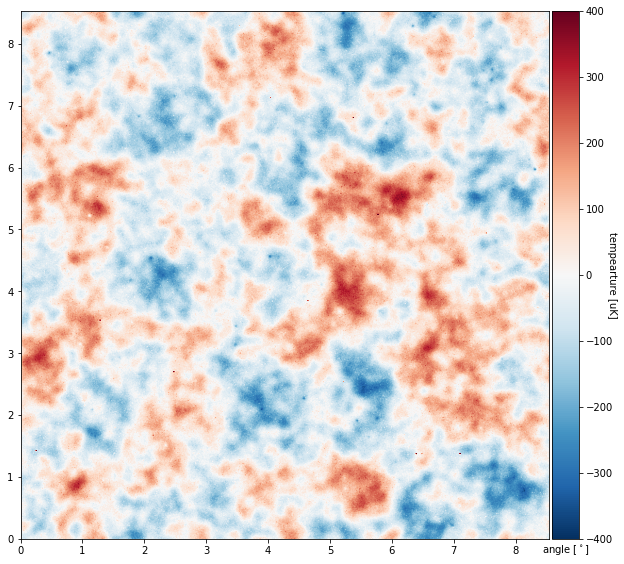

In [13]:
def solve_full(dataset, shape, niter=100, verbose=True):
    """Solve the full map-making equation
    Ax=b, where A = P'N"P and b = P'N"d."""
    # Set up our A matrix. We don't compute
    # explicitly because it's too big. Instead,
    # we define it as a function that can be applied
    # to a vector x. We will then use Conjugate Gradients
    # to invert it.
    def A(x):
        # x is 1d because the conjugate gradient solver works
        # on 1d arrays. So start by expanding it to 2d.
        x   = x.reshape(shape)
        res = x*0
        for data in dataset:
            tod  = Observe_map(x, data.point)
            tod  = mul_inv_noise(tod, data.noise_spec)
            res += PT(tod, data.point, shape)
        return res.reshape(-1)
    # Build our right-hand side b
    b = np.zeros(shape)
    for data in dataset:
        tod = mul_inv_noise(data.tod, data.noise_spec)
        b  += PT(tod, data.point, shape)
    # And solve
    cg = CG(A, b.reshape(-1))
    while cg.i < niter:
        cg.step()
        if verbose: print("iteration: %4d conjugate gradient error: %15.7e" % (cg.i, cg.err))
    return cg.x.reshape(shape)



def mul_inv_noise(tod, noise_spec):
    """Multiply by the inverse noise matrix. We assume that the noise
    is stationary, which means that it can be represented by a simple
    power spectrum noise_spec. This function is used to apply inverse
    variance weighting to the data."""
    ftod  = np.fft.fft(tod)
    ftod /= noise_spec
    return np.fft.ifft(ftod).real


def default_M(x):     return np.copy(x)
def default_dot(a,b): return a.dot(np.conj(b))
class CG:
    """A simple Preconditioned Conjugate gradients solver. Solves
    the equation system Ax=b."""
    def __init__(self, A, b, x0=None, M=default_M, dot=default_dot):
        """Initialize a solver for the system Ax=b, with a starting guess of x0 (0
        if not provided). Vectors b and x0 must provide addition and multiplication,
        as well as the .copy() method, such as provided by numpy arrays. The
        preconditioner is given by M. A and M must be functors acting on vectors
        and returning vectors. The dot product may be manually specified using the
        dot argument. This is useful for MPI-parallelization, for example."""
        # Init parameters
        self.A   = A
        self.b   = b
        self.M   = M
        self.dot = dot
        if x0 is None:
            self.x = b*0
            self.r = b
        else:
            self.x   = x0.copy()
            self.r   = b-self.A(self.x)
        # Internal work variables
        n = b.size
        self.z   = self.M(self.r)
        self.rz  = self.dot(self.r, self.z)
        self.rz0 = float(self.rz)
        self.p   = self.z
        self.err = np.inf
        self.d   = 4
        self.arz = []
        self.i   = 0
    def step(self):
        """Take a single step in the iteration. Results in .x, .i
        and .err being updated. To solve the system, call step() in
        a loop until you are satisfied with the accuracy. The result
        can then be read off from .x."""
        Ap = self.A(self.p)
        alpha = self.rz/self.dot(self.p, Ap)
        self.x += alpha*self.p
        self.r -= alpha*Ap
        self.z = self.M(self.r)
        next_rz = self.dot(self.r, self.z)
        self.err = next_rz/self.rz0
        beta = next_rz/self.rz
        self.rz = next_rz
        self.p = self.z + beta*self.p
        self.arz.append(self.rz*alpha)
        self.i += 1






print("Solving for map while taking noise correlations into account")
map_full  = solve_full(dataset, sky.shape,niter=50)

p=Plot_CMB_Map(map_full - np.mean(map_full),c_min,c_max,X_width,Y_width)

### maps with out cross linking

Solving for map while taking noise correlations into account
iteration:    1 conjugate gradient error:   3.4879924e-03
iteration:    2 conjugate gradient error:   8.2541861e-05
iteration:    3 conjugate gradient error:   2.7280534e-06
iteration:    4 conjugate gradient error:   2.4264414e-06
iteration:    5 conjugate gradient error:   1.4353452e-06
iteration:    6 conjugate gradient error:   1.0029555e-06
iteration:    7 conjugate gradient error:   6.4167423e-07
iteration:    8 conjugate gradient error:   6.3140913e-07
iteration:    9 conjugate gradient error:   5.5047701e-07
iteration:   10 conjugate gradient error:   4.5020069e-07
iteration:   11 conjugate gradient error:   3.6497174e-07
iteration:   12 conjugate gradient error:   2.8322526e-07
iteration:   13 conjugate gradient error:   2.6107856e-07
iteration:   14 conjugate gradient error:   2.0403114e-07
iteration:   15 conjugate gradient error:   1.9492610e-07
iteration:   16 conjugate gradient error:   1.8069305e-07
iteration: 

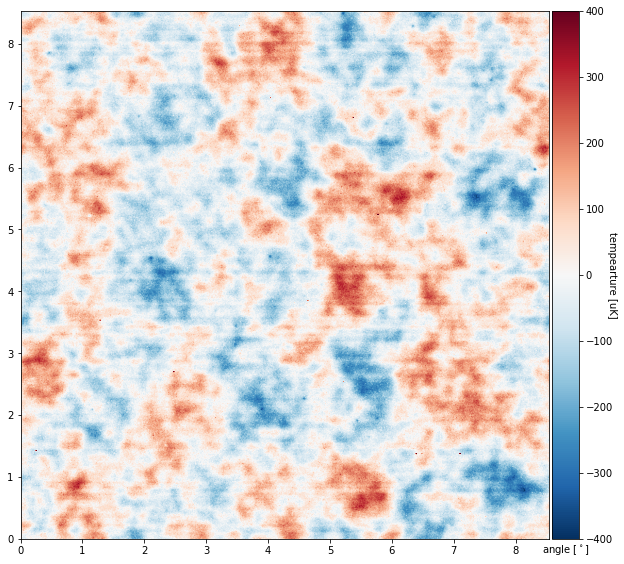

In [14]:
print("Solving for map while taking noise correlations into account")
map_single = solve_full(dataset[0:1], sky.shape,niter=50)

p=Plot_CMB_Map(map_single - np.mean(map_single),c_min,c_max,X_width,Y_width)



<font color='red'>EXCERCISE: </font>  Compare the cross-linked and non-crosslinked maps.  The horizontal strips in the non-crosslinked maps are refered to (uncreatively) as stripes.

<font color='red'>EXCERCISE: </font>  Make plots of these maps in 2-d fourier space

In [15]:
## your code goes here

 Compare these 2d fourier plots here. Be sure to note where modes are missing or de-weighted in each map. 

<font color='red'>EXCERCISE: </font>  Filter the non-crosslinked map to remove the stripes.  The can be accomplised by masking the relevent modes in your 2d fourier plot before inverse fouerier transforming to create the map.

In [16]:
## your code goes here

comment on the difference between the filter map non-crosslinked map, the crosslinked map, and the input map.   Make difference plots if that seems useful.